In [224]:
# Imports
from iexfinance.stocks import Stock
import requests
import urllib.parse
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [1]:
# Set-up
period = 'quarter'
time = '24'
symbol = "ADBE"

In [387]:
# URL set-up
income_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/income?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
cash_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/cash-flow?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
balance_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/balance-sheet?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219'
financials_url = f"https://sandbox.iexapis.com/stable/stock/{symbol}/financials?period={period}&last={time}&token=Tsk_910a8ace8ad14af698bc4a65be1a4219"
fundamentals_url = f"https://sandbox.iexapis.com/stable/time-series/fundamentals/{symbol}/{period}ly?range={time}q&token=Tsk_910a8ace8ad14af698bc4a65be1a4219"
stats_url = f"https://sandbox.iexapis.com/stable/stock/{symbol}/stats?token=Tsk_910a8ace8ad14af698bc4a65be1a4219"

In [388]:
# URL request
income = pd.DataFrame(requests.get(income_url).json()['income'])
cash = pd.DataFrame(requests.get(cash_url).json()['cashflow'])
balance = pd.DataFrame(requests.get(balance_url).json()['balancesheet'])
financials = pd.DataFrame(requests.get(financials_url).json()['financials'])
stats = requests.get(stats_url).json()

In [389]:
tables = [income,cash,balance,financials]

In [405]:
financials['merger'] = financials[['fiscalYear', 'fiscalQuarter']].astype('str').agg('-'.join, axis=1)

In [240]:
def lower_columns(ls):
    for table in ls:
        table.rename(str.lower, axis='columns', inplace=True)

In [406]:
def date_to_index(ls):
    for table in ls:
        table.set_index(pd.to_datetime(table['fiscaldate'].apply(lambda x: x[:7])), inplace=True)

In [407]:
lower_columns(tables)
date_to_index(tables)

In [446]:
# Collection table
collection = pd.DataFrame()
collection = financials[['revenue','netincome','operatingincome','cashflow','ebitda','totalassets','totalcash','totaldebt','shareholderequity','merger']]
collection['fcf'] = cash['cashflow'] + cash['capitalexpenditures']

/Users/admin/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [431]:
collection_q = collection
collection_q['time'] = 'q'
collection_y = collection.groupby(pd.Grouper(freq='y')).agg({'revenue':'sum', 'netincome':'sum', 'operatingincome':'sum'})
collection_y['time'] = 'y'

/Users/admin/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [432]:
def add_profitability(df):
    df['operating_margin'] = df['operatingincome'] / df['revenue']
    df['net_margin'] = df['netincome'] / df['revenue']
    df['asset_turnover'] = df['revenue'] / df['totalassets']
    df['roa'] = df['netincome']*4/ df['totalassets']
    df['equity_multipl'] = df['totalassets'] / df['shareholderequity']
    df['roe'] = df['netincome'] / df['shareholderequity']
    df['fcf_margin'] = df['fcf'] / df['revenue']

In [434]:
def add_financial_strength(df):
    df['cash_debt'] = df['totalcash'] / df['totaldebt']
    df['equity_asset'] = df['shareholderequity'] / df['totalassets']
    df['debt_equity'] = df['totaldebt'] / df['shareholderequity']
    df['debt_ebitda'] = df['totaldebt'] / (df['ebitda']*4)

In [435]:
add_profitability(collection_q)
add_financial_strength(collection_q)

/Users/admin/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/admin/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/admin/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is 

In [454]:
collection_q.columns

Index(['revenue', 'netincome', 'operatingincome', 'cashflow', 'ebitda',
       'totalassets', 'totalcash', 'totaldebt', 'shareholderequity', 'merger',
       'fcf', 'time', 'operating_margin', 'net_margin', 'asset_turnover',
       'roa', 'equity_multipl', 'roe', 'fcf_margin', 'cash_debt',
       'equity_asset', 'debt_equity', 'debt_ebitda'],
      dtype='object')

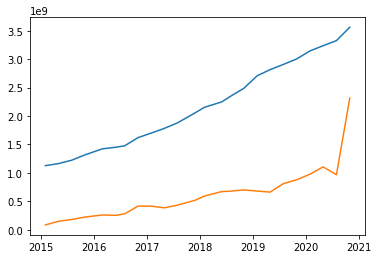

In [461]:
plt.plot(collection_q[['revenue','netincome']])

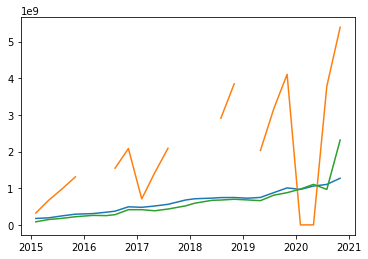

In [462]:
plt.plot(collection_q[['operatingincome','fcf','netincome']])